In [1]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values
import sqlite3
import sqlite_utils
import time
import statistics


In [20]:
def is_forward(x, y , side) :
    a = -1
    b = 16000 - a* 0

    y_diag = a * x+b

    if side == 100: #blue side
        if y > y_diag :
            return True
        else :
            return False
    if side == 200 : #Red side, on inverse alors
        if y > y_diag :
            return False
        else :
            return True

In [2]:
mid_kr_puuid = "yke-_ZuAP9wM6s3tpe-FnVWLlnwI4qLuLRzz933HfpI_jzKcDa1YwXbWGpFC7WJek_rv4x_kXk2Y-A"

In [3]:
conn = sqlite3.connect('koren_soloq_db.db')
cursor = conn.cursor()
match_end_data = cursor.execute('''SELECT metadata, info FROM MATCH_DATA''').fetchall()
match_timeline_data = cursor.execute('''SELECT metadata, timelineinfo FROM MATCH_DATA''').fetchall()

conn.close()

In [4]:
#Filter only mid role games
list_match_end_data_whereMid = []
mid_matchs = []
for idx_match, match in enumerate(match_end_data) :
    match_info = json.loads(match[1])
    for idx, participant in enumerate(match_info['participants']):
        if (participant['puuid'] == mid_kr_puuid) and (participant['teamPosition'] == "MIDDLE"):
            list_match_end_data_whereMid.append(match)
            mid_matchs.append(idx_match)

list_match_timeline_data_whereMid = [match_timeline_data[i] for i in mid_matchs]

In [5]:
print(len(match_end_data))
print(len(list_match_end_data_whereMid))
print(len(list_match_timeline_data_whereMid))

600
505
505


In [34]:
#Info after game
kda_list = []
cs_min = []
champion_list  = []
for match in list_match_end_data_whereMid :


    match_metadata = json.loads(match[0])
    for idx, player_puuid in enumerate(match_metadata['participants']):
        if player_puuid == mid_kr_puuid:
            index_qing = idx

    match_info = json.loads(match[1])

    #KDA
    kills = match_info['participants'][index_qing]['kills']
    assists = match_info['participants'][index_qing]['assists']
    deaths = match_info['participants'][index_qing]['deaths']
    if deaths == 0 : deaths = 1
    kda_list.append((kills+assists)/deaths)

    #CS/MIN
    monster_cs = match_info['participants'][index_qing]['neutralMinionsKilled']
    minion_cs = match_info['participants'][index_qing]['totalMinionsKilled']
    cs_min.append((monster_cs + minion_cs) /  (match_info['gameDuration'] //60))


    #Champions les plus joués
    champion = match_info['participants'][index_qing]['championName']
    champion_list.append(champion)




In [7]:
json.loads(list_match_end_data_whereMid[0][1])['participants'][0]['puuid']

'kKSPluUio3QQcAttyUdjul-d2m3rPrCRxxf4llXyzcwkwdtpnZ6PGHFY_NH7IQfgbgf-XPko4bZE8A'

In [21]:
json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['7']['position']

{'x': 14539, 'y': 14394}

In [9]:
json.loads(list_match_end_data_whereMid[0][1])['participants'][0]['teamId']

100

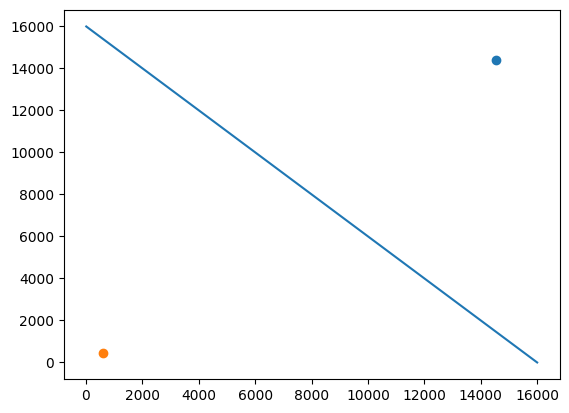

In [19]:
plt.plot(range(16000,0,-10),range(0,16000,10))
plt.scatter(json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['7']['position']['x'], json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['7']['position']['y'])
plt.scatter(json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['2']['position']['x'], json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['2']['position']['y'])

In [ ]:
#Info timeline
gold_diff_15_list = []
forward_percent =[]
for matchIndex, match in enumerate(list_match_timeline_data_whereMid):
    time_forward = []


    match_metadata = json.loads(match[0])
    for idx, player_puuid in enumerate(match_metadata['participants']):
        if player_puuid == mid_kr_puuid:
            index_qing = idx

    
    for idx, participant in enumerate(json.loads(list_match_end_data_whereMid[matchIndex][1])['participants']):
        if (participant['teamPosition'] == "MIDDLE") and (participant['puuid']) != mid_kr_puuid:
            index_ennemy = idx
            side_ennemy = participant['teamId']
            if side_ennemy == 100 : 
                side_qing = 200 
            else : 
                side_qing = 100
           

    match_info = json.loads(match[1])
    
    if len(match_info['frames']) > 16 :
        qing_gold_15 = match_info['frames'][15]['participantFrames'][str(index_qing+1)]['totalGold']
        ennemy_gold_15 = match_info['frames'][15]['participantFrames'][str(index_ennemy+1)]['totalGold']
        gold_diff_15_list.append(qing_gold_15 - ennemy_gold_15)

    for frame in match_info['frames'] :  
        x = frame['participantFrames'][str(index_qing+1)]['position']['x']
        y = frame['participantFrames'][str(index_qing+1)]['position']['y']

        time_forward.append(is_forward(x,y,side_qing))
    forward_percent.append(statistics.mean(time_forward))

    
        

# gold diff
# forward %

[0, 0.5925925925925926, 0.4, 0.23529411764705882, 0.125, 0.46875, 0.03225806451612903, 0.4166666666666667, 0.22580645161290322, 0.48717948717948717, 0.08, 0.6470588235294118, 0.47058823529411764, 0.5294117647058824, 0.46875, 0.3333333333333333, 0.5882352941176471, 0.5, 0.11764705882352941, 0.7741935483870968, 0.6538461538461539, 0.4444444444444444, 0.24, 0.3333333333333333, 0.5172413793103449, 0.17647058823529413, 0.5517241379310345, 0, 0.47368421052631576, 0, 0.37037037037037035, 0.2777777777777778, 0.15, 0.058823529411764705, 0.25, 0.41935483870967744, 0.5833333333333334, 0.7241379310344828, 0, 0.7419354838709677, 0.22857142857142856, 0.20833333333333334, 0.21739130434782608, 0.4117647058823529, 0.11764705882352941, 0.5, 0.4864864864864865, 0.2222222222222222, 0.7058823529411765, 0.07692307692307693, 0.8, 0, 0.11538461538461539, 0.2, 0.13636363636363635, 0.4230769230769231, 0.041666666666666664, 0.16129032258064516, 0.06451612903225806, 0.5, 0.46153846153846156, 0.3235294117647059, 0

In [33]:
#attention il a des games autofills
print(statistics.mean(kda_list))
print(statistics.mean(cs_min))
print(statistics.mean(gold_diff_15_list))
print(statistics.mean(forward_percent))

4.438730873087309
7.886367344876574
236.53493013972056
0.34231159283986196


In [37]:
champion_list

['Orianna',
 'Hwei',
 'Tristana',
 'Sylas',
 'Xerath',
 'Zoe',
 'Veigar',
 'AurelionSol',
 'AurelionSol',
 'Smolder',
 'Syndra',
 'Yone',
 'Syndra',
 'Syndra',
 'Aurora',
 'Hwei',
 'Aurora',
 'Syndra',
 'Hwei',
 'Hwei',
 'Yone',
 'Yasuo',
 'Yasuo',
 'Sylas',
 'Smolder',
 'Smolder',
 'Syndra',
 'Anivia',
 'Sylas',
 'Veigar',
 'Zoe',
 'Aurora',
 'Smolder',
 'Syndra',
 'Jayce',
 'Syndra',
 'Jayce',
 'Syndra',
 'Hwei',
 'Syndra',
 'Vex',
 'Sylas',
 'Sylas',
 'Ezreal',
 'Akshan',
 'Lucian',
 'Smolder',
 'Jayce',
 'Veigar',
 'Diana',
 'Diana',
 'AurelionSol',
 'AurelionSol',
 'Veigar',
 'AurelionSol',
 'Lissandra',
 'Zoe',
 'Vex',
 'Smolder',
 'Tristana',
 'Syndra',
 'Sylas',
 'Hwei',
 'Yone',
 'Hwei',
 'Vladimir',
 'Smolder',
 'Diana',
 'Veigar',
 'Zoe',
 'Hwei',
 'Ahri',
 'Ahri',
 'Aurora',
 'Hwei',
 'Jayce',
 'Taliyah',
 'Taliyah',
 'Hwei',
 'Veigar',
 'Veigar',
 'Sylas',
 'Smolder',
 'Vex',
 'Veigar',
 'Smolder',
 'Smolder',
 'Diana',
 'Corki',
 'Ahri',
 'Aurora',
 'Taliyah',
 'Hwei',
 '

In [40]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

In [47]:
from collections import Counter

count_champs = Counter(champion_list)
print(count_champs)

Counter({'Smolder': 76, 'Aurora': 51, 'Syndra': 48, 'Sylas': 41, 'Hwei': 40, 'Jayce': 38, 'Orianna': 25, 'Taliyah': 25, 'Veigar': 24, 'Yone': 13, 'Vex': 13, 'Ahri': 13, 'AurelionSol': 11, 'Galio': 11, 'Zoe': 8, 'Ziggs': 8, 'Tristana': 7, 'Diana': 7, 'Akshan': 6, 'Corki': 6, 'Ryze': 5, 'Tryndamere': 5, 'Yasuo': 3, 'Garen': 3, 'Zeri': 3, 'Xerath': 2, 'TwistedFate': 2, 'Anivia': 1, 'Ezreal': 1, 'Lucian': 1, 'Lissandra': 1, 'Vladimir': 1, 'Jhin': 1, 'Neeko': 1, 'Akali': 1, 'Leblanc': 1, 'Nasus': 1, 'Sivir': 1})


In [72]:
import random

N = len(count_champs)

# liste de couleurs hexadécimales
liste_couleurs_hex = [f'#{random.randint(0, 0xFFFFFF):06X}' for _ in range(N)]


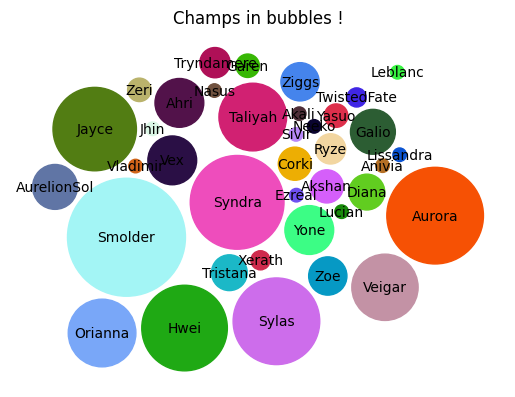

In [71]:
#ADD YOUR DATA HERE

#STEP 3
bubble_chart = BubbleChart(area=list((count_champs.values())),
                           bubble_spacing=0.5)
#STEP 4
bubble_chart.collapse()

#STEP 5

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, list((count_champs.keys())),liste_couleurs_hex)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Champs in bubbles !')

plt.show()